In [1]:
#################################################################################################################################
#
# NIST Programming challenges
#
# Building 'Correlation Histogram' (data is read in from a pytables object)
# After optimizing the histogram's construction, analysis of the dissociation of specific molecules 
# can be plotted very accurately as parametric lines
#
# These functions are used in the main application to perform analysis on arbitrary data
#
# amibiguous molecules can be identified using this histogram and plotting various dissociation to see which daughter ions 
# combine to fit the scatterplot data
# 
#################################################################################################################################
#################################################################################################################################
# Imports
# coding: utf-8
import os
import tables
import numpy as np
import sys
import struct
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import pandas as pd

#################################################################################################################################
#################################################################################################################################
#
# The purpose of 'Atom Probe' data analysis is to analyse the composition of materials in a sample
# this is done by ionizing the sample and reomving layers of ionized molecule species which are captured on 
# a detector pad. This dataset is often 50,000,000 in magnitude or larger, but careful analysis can be useful in idetifying
# the potential atomic species in the sample. 
# one method is building a histogram which plots mass-to-charge ratio against the frequency of occurence of this mass-to-charge 
# in the specific data set.  Ions can be identified by mass-to-charge ration
# 
# One important subapplication of the program is the use of a 'Correlation Histogram' to identify more ambiguous molecule species.
# this is accomplished by analyzing multiple hit events, which may mask the dissociation of compound molecules and lead to 
# thier incorrect identification during analysis.  
# ** An example that isn't necessarily accurate:  FeO3 and Si3 may have the same mtc.  plotting a single hit histogram would 
# show one ambiguous peak that could be either species:  by 'breaking apart' this peak, we could visualize the dissociation of this
# molecule and correctly identify it. 
# 'correlation histogram' plots a 2-dimensional histogram of multiple detector hit events from the experiments
# this histogram plots the first-of-multiple events against the !first-of-multiple events -- the rationale is to visualize 
# potential molecule dissociations.  It's clearer below where the histogram is actually built.


# Data from Mass spectrometric experiments is recorded in an ePOS file, which contains various data
# including time of flight from the sample to the detector pad, XY coordinates of hit on detector pad,
# and recontruction of Z coordinates from time of flight and other data
# this is used to calculate the mass-to-charge ratio of the ion captured on the detector pad
# The number of ions per electric pulse is also recorded during the experiment -- relevancy of this is explained in more
# detail below

#################################################################################################################################

# Read in pyTables object -- be sure to edit this line 
# Paste in path to pyTables *.h5 file made from .epos file
EPOS_PATH = "H:\APT_Composition_App\mch_code\Zircon data set example\\"
ePosPyFileName = "ePosPyTable_R44-02411.h5"

# Open pytable
ePosPyFile = tables.open_file(EPOS_PATH+ePosPyFileName, mode='r')
aTable = ePosPyFile.root.ePosDataGroup.ePosDataTable


In [2]:
#################################################################################################################################
#
# Numpy Array Construction
# Extract the needed data from pyTable
# For the correlation analysis, only the mtc data and nIonsPerPulse data is needed

# Create numpy arrays from the data in pyTables
# Conditional filters only multiple hit events -- which are nonzero, non-one values followed
# by the corresponding number of zeros
# 
#################################################################################################################################

mtcArray = np.array([x['mtc'] for x in aTable.iterrows() if x['nIonsPerPulse'] != 1])
multiple_hits= np.array([x['nIonsPerPulse'] for x in aTable.iterrows() if x['nIonsPerPulse'] != 1])


# # The following arrays are pulled from the ePos data
# # they will be merged into a pandas df 
# mtc = np.array([x['mtc'] for x in aTable.iterrows()])
# #nPulseInterval = np.array([x['nPulseInterval'] for x in aTable.iterrows()])
# nIonsPerPulse = np.array([x['nIonsPerPulse'] for x in aTable.iterrows()])
ePosPyFile.close()


In [3]:
#################################################################################################################################
#
# Array Testing and getting the correct data for the correlation Histogram
# For the histogram, we are only interested in the first- and !first-of-multiples events from the experiment
# Constructing a matrix from numpy arrays makes the data a bit easier to see and
# understand
#
#################################################################################################################################


mtcArray


array([ 31.10869217,  53.90369415,  59.54545212, ...,  53.80692291,
        57.01412964,  58.96030045])

In [4]:
multiple_hits

array([3, 0, 0, ..., 0, 2, 0], dtype=int64)

In [5]:
mat = np.column_stack((multiple_hits,mtcArray))
print mat[0]

[  3.          31.10869217]


In [6]:
#################################################################################################################################
#
# This is the matrix of the data that's going to be plotted.  the first column is the magnitude of ions per pulse
# the first one is a three hit event, where the first hit records a three and the consecutive 2 are recorded as 0's
# the second column is mtc
#
#################################################################################################################################

print mat[0:10]

[[  3.          31.10869217]
 [  0.          53.90369415]
 [  0.          59.54545212]
 [  2.          53.09857941]
 [  0.          60.22142029]
 [  5.          14.07777119]
 [  0.          28.30118561]
 [  0.          32.08707428]
 [  0.          35.49623489]
 [  0.          54.09199524]]


In [9]:
len(mat)

5455905

In [10]:
################################################################################################################################
#
# A nonzero entry in mult_hits arrays corresponds to the first event in a multi-hit event
# the following zeros signify the consecutive events in that multi-hit
# The corresponding mtc is the value of the mtc for that particular event
#
################################################################################################################################

#print all rows & second column
print mat[:,1][0:10]


[ 31.10869217  53.90369415  59.54545212  53.09857941  60.22142029
  14.07777119  28.30118561  32.08707428  35.49623489  54.09199524]


In [ ]:
#################################################################################################################################
#
# FIRST METHOD
#
# Assemble histogram with nested for loops. Looping through the data is not super efficient... is there a clever way to
# use numpy's array operations to build the histogram instead?
# can definitely improve the runtime (currently it's O((n^2)logn))
# performance evaluation: about 55 seconds for construction + visualization over 25 iterations

# i = 0
# while i < len(mtcArray):  # Step through mtcArray
#     # Each multi-hit events can, in general, include any number of detector hits >= 2.  Only the first
#     # hit in a particular multi-hit event has nIonsPerPulse > 0. (smart)
#     if nIonsPerPulseList[i] > 0:  # If it's the first hit in a multi-hit event
#         setStart = i  # Starting index of this multi-hit event
#         setEnd = setStart+nIonsPerPulseList[i]  # Starting index of next multi-hit event
#         multiIonMTCSet = mtcArray[setStart:setEnd]  # Section of mtcArray corresponding to this multi-hit event
#         # Loop through and get each possible pair of multi-hits from within this event
#         # This actually duplicates each pair, leading to symmetry in the mass correlation histogram
#         # across the diagonal.  We could change it to only use the data either above or below the diagonal
#         # in order to save memory, since the duplication provides no new information.
#         for k in range(len(multiIonMTCSet)):
#             for m in range(len(multiIonMTCSet)):
#                 if k != m:  # Don't correlate a hit with itself
#                     # Calculate the histogram bin index of each hit in the pair
#                     kIdx = int(np.ceil(multiIonMTCSet[k]/bwCorrHist))-1
#                     mIdx = int(np.ceil(multiIonMTCSet[m]/bwCorrHist))-1
#                     if kIdx < nBins and mIdx < nBins:  # Limit to mtc < maxDa.  
#                         corrHistArray[kIdx,mIdx]+=1  # Add a count to the appropriate 2D bin
#         i=setEnd       

# sys.stdout.write("...done\n")

# # Put the number of bin counts on a logarithmic scale so that the relatively faint tracks show up.
# # Add a dummy minimum value of 0.1 counts to each bin to avoid taking the log of zero.
# lnCorrHistArray = np.log(corrHistArray+0.1)

# # An alternative approach to scaling is to simply cap the maximum bin count value (in this case,
# # set the count to 2 if it exceeds 2
# plotCountCap = 2.0
# exceedsCapArray = corrHistArray >= plotCountCap
# belowCapArray = corrHistArray < plotCountCap
# cappedHistArray = corrHistArray*belowCapArray+plotCountCap*exceedsCapArray

# aDPI = 100
# fig = plt.figure(figsize=((1.0*nBins)/aDPI,(1.0*nBins)/aDPI), dpi=300)
# ax = fig.add_subplot(111)
# cax = ax.matshow(lnCorrHistArray, origin="lower",cmap=plt.get_cmap('hot'))
# #cax = ax.matshow(cappedHistArray, origin="lower",cmap=plt.get_cmap('hot'),interpolation='none')

# fig.colorbar(cax)
# xScaleFactor = bwCorrHist
# yScaleFactor = xScaleFactor
# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*xScaleFactor))
# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*yScaleFactor))
# ax.xaxis.set_major_formatter(ticks_x)
# ax.yaxis.set_major_formatter(ticks_y)


# plt.savefig(EPOS_PATH+"CorrelationHistogram_01.png",dpi='figure')

In [11]:
#################################################################################################################################
# 
# SECOND METHOD
#
# slowly constructing the graph with the first method was fine for individual analysis, but incorporating the function into the
# main application required improvement of performance time. 
#
# Use Numpy arrays to get the correct data from pyTables
# second-of-multiples corresponds to all values from mtcArray where multiple_hits ==0, signifying that they are NOT 
# first events
# each second-of-multiple needs to be binned with its corresponding first event
# for an event with 5 detector hits, the first hit must be paired with each of the following four hits
# construct an array of first hits, where the first hit is repeated for every consecutive second-of-multiples hit
# so for an event with 5 hits,  the first event is recorded in the first hit array four times, to be paired with all 
# four following hits in that event
#
# this method signitificantly improved the performance time of construction and visualization: very useful for incorparating 
# into the main application
# performance evaluation: about 1 seconds for construction + visualization over 25 iterations
# ** bonus:  the first method created a mirror image of the histogram, which requires more memory and construction time.
# the second method eliminates repetition of data and saves a lot of time and memory, plus visualization is more accurate
#
################################################################################################################################

first_mtc = np.array(mtcArray[multiple_hits != 0])
#print "1 events array: ",first_mtc[0:10]
num_repeats = np.array(multiple_hits[multiple_hits != 0] -1)
#print "repeat factors: ",num_repeats[0:10]
f_mtc = np.repeat(first_mtc,num_repeats)
#print "1 event array including repeats: ",f_mtc[0:10]
s_mtc = np.array(mtcArray[multiple_hits == 0])
#print "All following events: ", second_mtc[0:10]


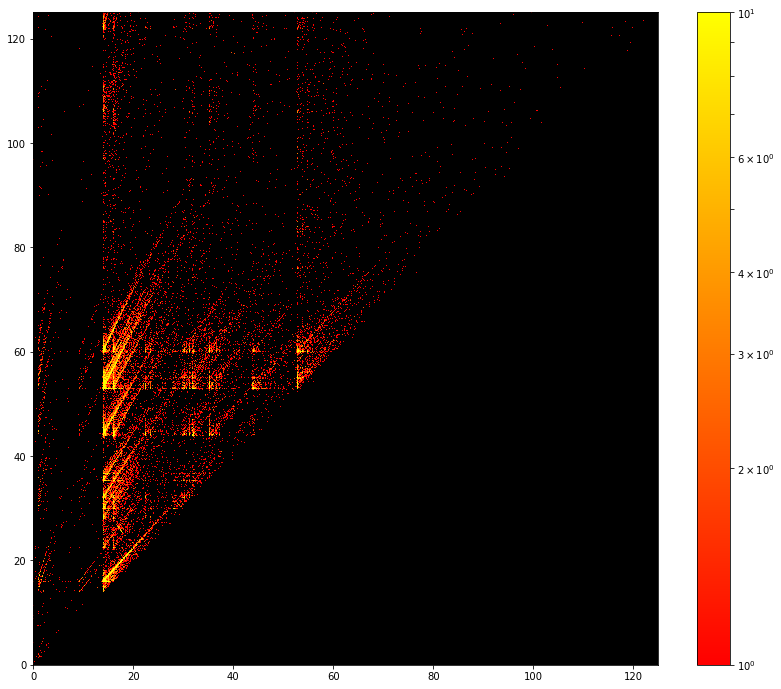

In [12]:
#################################################################################################################################
#
# Using 2dHist to plot numpy arrays
#
#################################################################################################################################

fig = plt.figure(figsize=(14,12))
#plt.hist2d(first_mtc, second_mtc, bins=7500)
ax = fig.add_subplot(111)
plt.hist2d(f_mtc,s_mtc, bins=(6250,6250), range=[[0,125],[0,125]],norm = LogNorm(vmax= 10), cmap = 'autumn')
plt.colorbar()
ax.set_facecolor('black')

plt.show()

In [16]:
#################################################################################################################################
#
# Usings imshow to plot numpy arrays 
# build histogram using numpyhistogram first
#
#################################################################################################################################


H, xedges, yedges = np.histogram2d(f_mtc, s_mtc, bins=(6250,6250), range = [[0,125],[0,125]])


In [17]:
#################################################################################################################################
# is a multi-dimensional array which contains each bincount and represents the number of detector hits at this position
#
#################################################################################################################################

H

array([[ 0.,  2.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [18]:
#################################################################################################################################
# Log count scales teh data to be visualizaed more easily
#################################################################################################################################

h_log = np.log(H +.1)
h_log

array([[-2.30258509,  0.74193734,  1.13140211, ..., -2.30258509,
        -2.30258509, -2.30258509],
       [-2.30258509, -2.30258509, -2.30258509, ..., -2.30258509,
        -2.30258509, -2.30258509],
       [-2.30258509, -2.30258509, -2.30258509, ..., -2.30258509,
        -2.30258509, -2.30258509],
       ..., 
       [-2.30258509, -2.30258509, -2.30258509, ..., -2.30258509,
        -2.30258509, -2.30258509],
       [-2.30258509, -2.30258509, -2.30258509, ..., -2.30258509,
        -2.30258509, -2.30258509],
       [-2.30258509, -2.30258509, -2.30258509, ..., -2.30258509,
        -2.30258509, -2.30258509]])

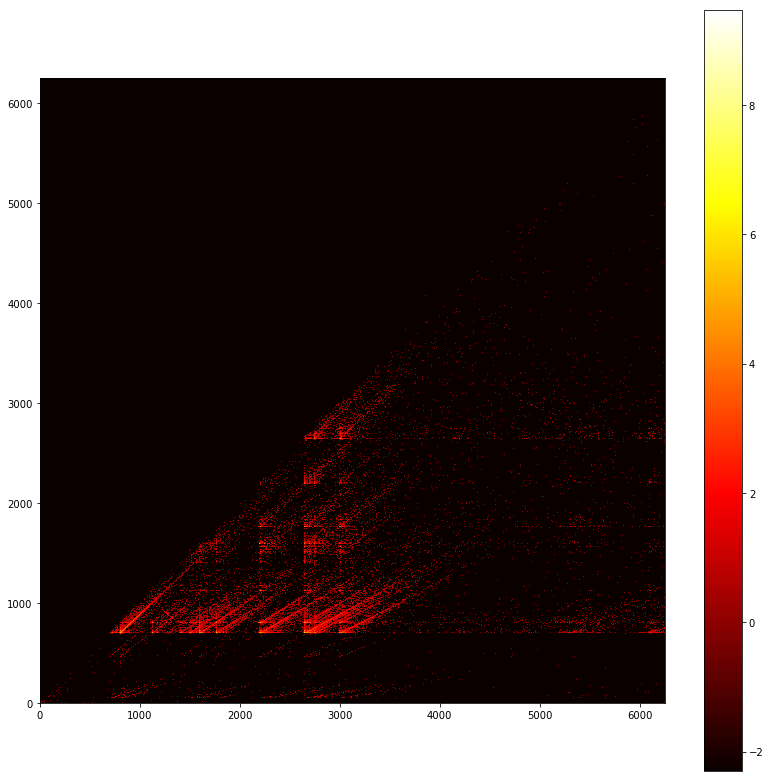

In [19]:
#################################################################################################################################
# result is a more accurate graph
#(performance of this method is faster by about 1 second than using the builtin 2d hist method as well)
#
#################################################################################################################################

fig2 = plt.figure(figsize=(14,14))
ax = fig2.add_subplot(111)
im = plt.imshow(h_log, origin='low', cmap = 'hot')
fig2.colorbar(im)
plt.show()


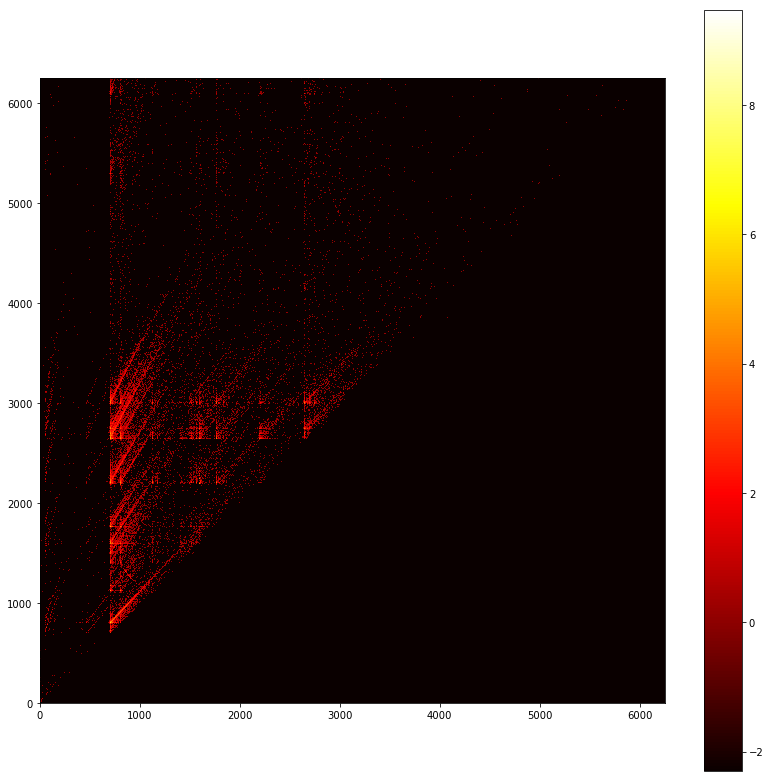

In [20]:
# Transpose
H, xedges, yedges = np.histogram2d(f_mtc, s_mtc, bins=(6250,6250), range = [[0,125],[0,125]])
h_log = np.log(H +.1)
fig2 = plt.figure(figsize=(14,14))
ax = fig2.add_subplot(111)
im = plt.imshow(h_log.T, origin='low', cmap = 'hot')
fig2.colorbar(im)
plt.show()


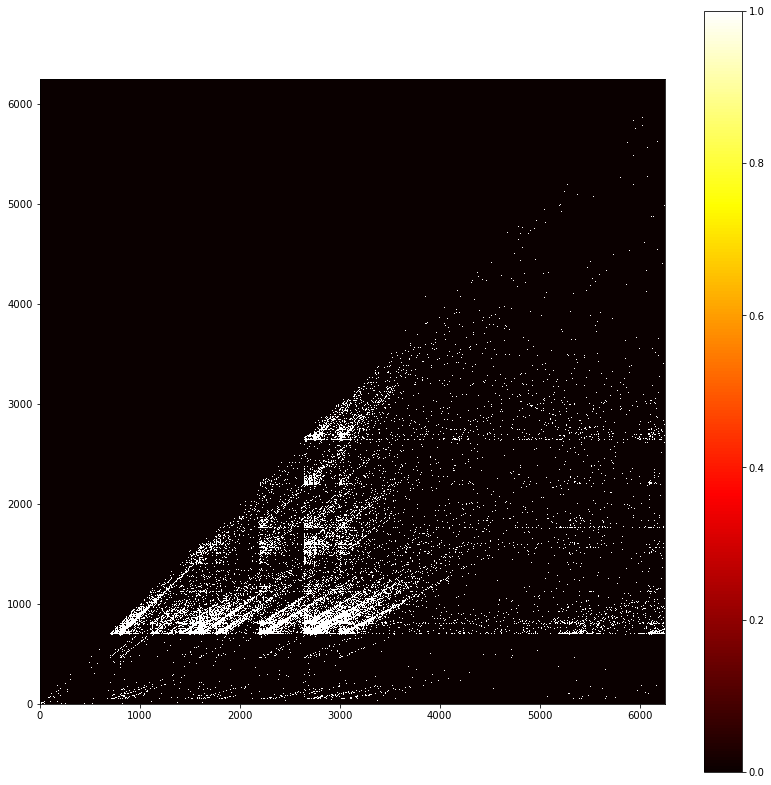

In [21]:
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig2 = plt.figure(figsize=(14,14))
ax = fig2.add_subplot(111)
im = plt.imshow(H, origin='low', cmap = 'hot', norm = norm)
fig2.colorbar(im)
plt.show()

In [22]:
print xedges

[  0.00000000e+00   2.00000000e-02   4.00000000e-02 ...,   1.24960000e+02
   1.24980000e+02   1.25000000e+02]


In [23]:
print yedges

[  0.00000000e+00   2.00000000e-02   4.00000000e-02 ...,   1.24960000e+02
   1.24980000e+02   1.25000000e+02]


In [24]:
print type(xedges)

<type 'numpy.ndarray'>


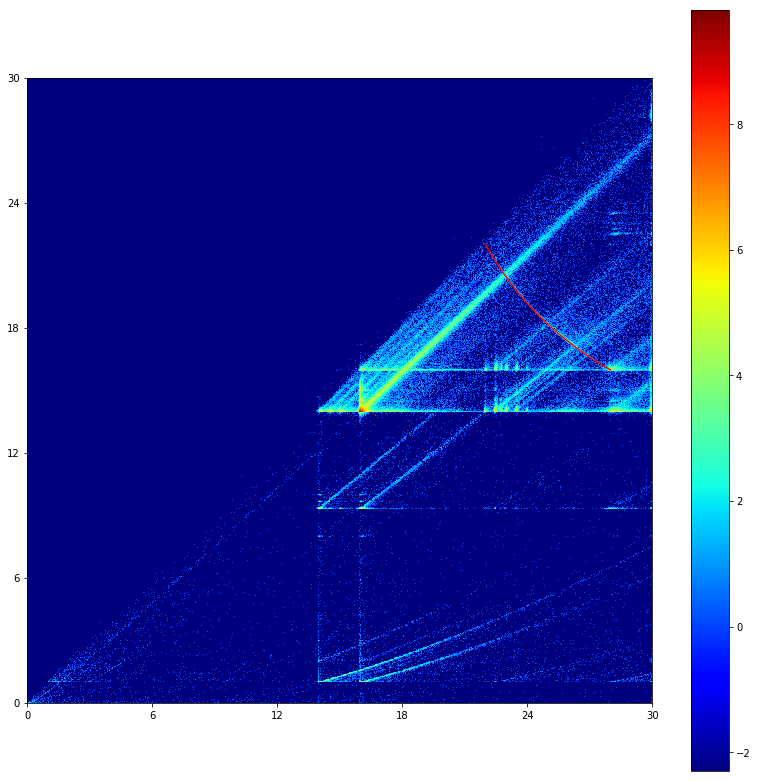

In [25]:
#################################################################################################################################
# 
# How to use the histogram for analysis
# equations and method taken from:
# D.W. Saxey, Correlated ion analysis and the interpretation of atom probe mass spectra, In Ultramicroscopy, Volume 111, Issue 6, 2011, Pages 473-479, ISSN 0304-3991, https://doi.org/10.1016/j.ultramic.2010.11.021.
# http://www.sciencedirect.com/science/article/pii/S0304399110003116
# Keywords: Atom probe tomography; Time-of-flight mass spectrometry; Ion dissociation
# ** honestly, this is a 100% better explanation of the experimenetation than I provided above if you're bored and feel 
# up to reading about particle physics
#
# Saxey details the dissociation of ions with equation (2.8) from the article
# I've hardcoded the equation to fit a particularly visible dissociation pathway around (27.9,15.9) which I later identified as SiO

################################################################################################################################# 

H, xedges, yedges = np.histogram2d(f_mtc, s_mtc, bins=(1000,1000), range = [[0,30],[0,30]])
t = range(0,5000)
h_log = np.log(H +.1)
fig2 = plt.figure(figsize=(14,14))
ax = fig2.add_subplot(111)
xScaleFactor = .03
yScaleFactor = .03
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*xScaleFactor))
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*yScaleFactor))
ax.xaxis.set_major_formatter(ticks_x)
ax.yaxis.set_major_formatter(ticks_y)
im = plt.imshow(h_log, origin='low', cmap = 'jet')
x = [(27.99*(1-((i/5000.)*(1.-(27.99/22.))))**-1.)/.03 for i in t]
y = [(15.99*(1-((i/5000.)*(1.-(15.99/22.))))**-1.)/.03 for i in t]
plt.plot(x,y,'r')
fig2.colorbar(im)
plt.show()


In [1]:
#################################################################################################################################
# How to incorporate these functions into the application to provide a useful tool for analysis?
# first, we thought to start with the parent ion and calculate all possible dissociations of this ion into 
# two daughter ions, and display each of these parametric linesa against the histogram 
# the line that matches the scatterplot most closely would likelt be the correct dissociation and the correct
# below are the functions I wrote to calculate all possible dissociations of an input parent molecule
# into two daughter ions
# 
# when loading the data sets and doing analysis, data structures are built in the program to hold various information 
# about different molecular species
# including a list of possible molecule species for each mtc value
# the idea was that the user could click a mass-to-charge ratio from a list in the UI where peaks in the spectrum are identified
# choose a molecule from the list
# and the program would output a list of possible dissociation reactions for the user to plot over the scatter
# 
# after some manual testing, we decided to do this analysis in reverse by selecting the daughter ions and computing the 
# parent ion that would dissociate into these daughters, which was a much easier computation
# in short, the programs below weren't used but it was a fun and challenging computational problem with strings that
# could be useful in future UI projects
#
#################################################################################################################################
# import numpy as np
# import itertools
# #Return r length subsequences of elements from the input iterable.
# #Combinations are emitted in lexicographic sort order. 
# #So, if the input iterable is sorted, the combination tuples will be produced in sorted order.
# x = np.array([1,1,0,0,0,0])
# print x
# np.array_split(x, 2)

In [2]:
# def partitions(s, k):
#     if not k:
#         yield [s]
#         return
#     for i in range(len(s) + 1):
#         for tail in partitions(s[i:], k - 1):
#             yield [s[:i]] + tail
            
# n = list(partitions('oooo',1))
# m = list(partitions('hh',1))
# o = list(partitions('s',1))
# print n
# print m
# print o

In [3]:
# results= []
# for i in range(len(m)):
#     for j in range(len(n)):
#         for k in range(len(o)):
#             if (m[i][0]+n[j][0])+o[k][0] != '' and (m[i][1]+n[j][1]+o[k][1]) != '':
#                 print m[i][0]+n[j][0]+o[k][0], '+', m[i][1]+n[j][1]+o[k][1]

In [4]:
import re
charge_state = 0
charge_state+= int('C6H12O6+3'.split('+')[1])
charge_state+= int('C6H12O6+3'.split('+')[1])
print charge_state
re.findall(r'[A-Z][a-z]?\d*', 'C6H12O6+3')

6


['C6', 'H12', 'O6']

In [5]:
split_molecule =(re.findall(r'([A-Z][a-z]*)(\d*)', 'H2O4'))
split_mol_2 = (re.findall(r'([A-Z][a-z]*)(\d*)', 'SiO'))
print split_molecule
print split_mol_2

[('H', '2'), ('O', '4')]
[('Si', ''), ('O', '')]


In [6]:
molecule_list = []
molecule_string = ''
for tuple in range(len(split_molecule)):
    if split_molecule[tuple][1] == '':
        split_molecule[tuple] = (split_molecule[tuple][0],'1')
    piece = ''
    for count in range(int(split_molecule[tuple][1])):
        piece += split_molecule[tuple][0]
        molecule_string += split_molecule[tuple][0]
        molecule_list.append(split_molecule[tuple][0])
for tuple in range(len(split_mol_2)):
    if split_mol_2[tuple][1] == '':
        split_mol_2[tuple] = (split_mol_2[tuple][0],'1')
    piece = ''
    for count in range(int(split_mol_2[tuple][1])):
        piece += split_mol_2[tuple][0]
        molecule_string += split_mol_2[tuple][0]
        molecule_list.append(split_mol_2[tuple][0])
print split_molecule
print molecule_list
print molecule_string

[('H', '2'), ('O', '4')]
['H', 'H', 'O', 'O', 'O', 'O', 'Si', 'O']
HHOOOOSiO


In [7]:
f_mol = [(i,str(molecule_list.count(i))) for i in set(molecule_list)]
print f_mol

for y in range(len(f_mol)):
        if f_mol[y][1] == '1':
            f_mol[y] = (f_mol[y][0],'')
formula = ''.join(map(''.join,f_mol))        
print f_mol
print formula

[('H', '2'), ('Si', '1'), ('O', '5')]
[('H', '2'), ('Si', ''), ('O', '5')]
H2SiO5


In [8]:
##################################################################################################################################
#
# This function computes all possible ways to break a list into sublists
# duplicates (including reversed tuples) are removed
# passed to the function is a list of characters (in this case, the list represents a molecule)
# and returned is a triple nested list, with each entry as one possible case of sublists (in this case, all possible dissociations
# of molecule)
#################################################################################################################################
def two_sublists(molecule_list):    
    sublists = []
    # sets flags to the length of the molecule list
    flags = [False] * len(molecule_list)
    while True:
        # sets a and b according to flag values, if True in b and if False in a, splitting the list acccording to the flags
        a = [molecule_list[i] for i, flag in enumerate(flags) if flag]
        b = [molecule_list[i] for i, flag in enumerate(flags) if not flag]
        # remove reactions that are invalid because one side is empty
        if a != [] and b != []:
            sublists.append([a,b])
        # toggle 'flags' boolean to iterate through all possible combos of flags
        for i in xrange(len(molecule_list)):
            flags[i] = not flags[i]
            if flags[i]:
                break
        else:
            break
    sublists.sort()
#     remove_duplicates = list(sublists for sublists,_ in itertools.groupby(sublists))
#     for i in range(len(remove_duplicates)):
#         print remove_duplicates[i]
    unique = []
    for item in sublists:
        if sorted(item) not in unique:
            unique.append(sorted(item))
    return unique


In [9]:
m_list = ["H","H","S","O","O","O","O"]
r_list = two_sublists(list(m_list))
for i in range(len(r_list)):
    print r_list[i]

[['H'], ['H', 'S', 'O', 'O', 'O', 'O']]
[['H', 'H'], ['S', 'O', 'O', 'O', 'O']]
[['H', 'H', 'O'], ['S', 'O', 'O', 'O']]
[['H', 'H', 'O', 'O'], ['S', 'O', 'O']]
[['H', 'H', 'O', 'O', 'O'], ['S', 'O']]
[['H', 'H', 'O', 'O', 'O', 'O'], ['S']]
[['H', 'H', 'S'], ['O', 'O', 'O', 'O']]
[['H', 'H', 'S', 'O'], ['O', 'O', 'O']]
[['H', 'H', 'S', 'O', 'O'], ['O', 'O']]
[['H', 'H', 'S', 'O', 'O', 'O'], ['O']]
[['H', 'O'], ['H', 'S', 'O', 'O', 'O']]
[['H', 'O', 'O'], ['H', 'S', 'O', 'O']]
[['H', 'O', 'O', 'O'], ['H', 'S', 'O']]
[['H', 'O', 'O', 'O', 'O'], ['H', 'S']]


In [10]:
# H2O4 = ['H','H','O','O','O','O']
# two_sublists(H2O4)

In [11]:

# for i in range(len(reactions_list)):
#     print reactions_list[i]
#     reactions_list[i][0] = ''.join(reactions_list[i][0])
#     reactions_list[i][1] =''.join(reactions_list[i][1])
#     print reactions_list[i]



In [12]:

import collections
# results = collections.Counter(the_string)
formulas = []
for x in range(len(reactions_list)):
    f_mol = [(i,str(reactions_list[x][0].count(i))) for i in set(reactions_list[x][0])]
    for y in range(len(f_mol)):
        if f_mol[y][1] == '1':
            f_mol[y] = (f_mol[y][0],'')
    s_mol = [(j,str(reactions_list[x][1].count(j))) for j in set(reactions_list[x][1])]
    for y in range(len(s_mol)):
        if s_mol[y][1] == '1':
            s_mol[y] = (s_mol[y][0],'')
    formula = ''.join(map(''.join,f_mol)) +' + ' +''.join(map(''.join,s_mol))
    formulas.append(formula)

for formula in formulas:
    print formula

NameError: name 'reactions_list' is not defined

In [13]:
########################################################################################################################
#
# Convert a chemical formula given as a string to all of its possible dissociation reactions
# 
########################################################################################################################


import numpy as np
import itertools
import re
import collections


def find_all_reactions(molecule):
    # Begin by parsing the chemical formula and storing it as a list of tuples
    # replace blanks with ones?
    # Convert the list of tuples to a list of elements, where each element tuple[0] is repeated tuple[1] times
    
    # example: H2O becomes [('H', '2'), (O, '1')]
    split_molecule =(re.findall(r'([A-Z][a-z]*)(\d*)', molecule))
    # example:  [('H', '2'), (O, '1')] becomes ['H','H','O']
    molecule_list = []
    for (element, count) in split_molecule:
        if count == '':
            count = 1
        molecule_list.extend([element] * int(count))
    # Next,compute all possible ways to break this list into two sublists
    # duplicates (including reversed tuples) are removed
    # this computes all possible chemical reactions from the given input molecule
    # setting each value in molecule list equal to a boolean flag and iterating thorugh all possible comb os of these flags 
    # gives all possible ways to split the list in half
    # the list is sorted and duplicates are removed 
    # reactions_list is a triple nested list, with each entry as one possible case of sublists (in this case, all possible dissociations of molecule)
    reactions = []
    flags = [False] * len(molecule_list)
    while True:
        a = [molecule_list[i] for i, flag in enumerate(flags) if flag]
        b = [molecule_list[i] for i, flag in enumerate(flags) if not flag]
        if a != [] and b != []:
            reactions.append([a,b])
        for i in xrange(len(molecule_list)):
            flags[i] = not flags[i]
            if flags[i]:
                break
        else:
            break
    reactions.sort()
#     remove_duplicates = list(sublists for sublists,_ in itertools.groupby(sublists))
    reactions_list = []
    for item in reactions:
        if sorted(item) not in reactions_list:
            reactions_list.append(sorted(item))
#     print reactions_list[0]

    # Finally, convert this list of lists back to tuples, where the first entry is the element and the second is the count
    # convert the tuples into chemical formulas using join (going backwards from the b
    formulas = []
    for x in range(len(reactions_list)):
        f_mol = [(i,str(reactions_list[x][0].count(i))) for i in set(reactions_list[x][0])]
        for y in range(len(f_mol)):
            if f_mol[y][1] == '1':
                f_mol[y] = (f_mol[y][0],'')
        s_mol = [(j,str(reactions_list[x][1].count(j))) for j in set(reactions_list[x][1])]
        for y in range(len(s_mol)):
            if s_mol[y][1] == '1':
                s_mol[y] = (s_mol[y][0],'')
        formula = (''.join(map(''.join,f_mol)) ,''.join(map(''.join,s_mol)))
        formulas.append(formula)
    return formulas
#         print formula
#     print formulas
#     print type(formulas)

def print_reactions(reactions_list):
    for (element_one,element_two) in reactions_list:
        print element_one+ ' + ' + element_two
##################################################################################################################################

In [14]:
first = find_all_reactions('SiO')
print_reactions(first)

O + Si


In [15]:
second = find_all_reactions('H2SiO4')

In [16]:
print_reactions(second)

H + HSiO4
H2 + SiO4
H2O + SiO3
H2O2 + SiO2
H2O3 + SiO
H2O4 + Si
H2Si + O4
H2SiO + O3
H2SiO2 + O2
H2SiO3 + O
HO + HSiO3
HO2 + HSiO2
HO3 + HSiO
HO4 + HSi


In [17]:
mol = ['H_1', 'H_2', 'O_16', 'O_16', 'O_16', 'O_16']
split_mol = two_sublists(list(mol))
for i in range(len(split_mol)):
    print split_mol[i]

[['H_1'], ['H_2', 'O_16', 'O_16', 'O_16', 'O_16']]
[['H_1', 'H_2'], ['O_16', 'O_16', 'O_16', 'O_16']]
[['H_1', 'H_2', 'O_16'], ['O_16', 'O_16', 'O_16']]
[['H_1', 'H_2', 'O_16', 'O_16'], ['O_16', 'O_16']]
[['H_1', 'H_2', 'O_16', 'O_16', 'O_16'], ['O_16']]
[['H_1', 'O_16'], ['H_2', 'O_16', 'O_16', 'O_16']]
[['H_1', 'O_16', 'O_16'], ['H_2', 'O_16', 'O_16']]
[['H_1', 'O_16', 'O_16', 'O_16'], ['H_2', 'O_16']]
[['H_1', 'O_16', 'O_16', 'O_16', 'O_16'], ['H_2']]
